In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
def sign(x):
    return (x >= 0).astype(int)*2 - 1

In [41]:
d = 5
n = 500
# np.random.seed(1346)
w = np.random.randn(d)
# X = np.column_stack([
#     np.linspace(-10., 10., n),
#     np.ones((n, d-1))
# ])
X = np.random.rand(n, d) * 10. - 5. 
X.shape, w

((500, 5),
 array([ 0.79261988, -0.30030742,  1.34024595, -1.01478313, -1.22043189]))

In [42]:
Y = sign(X @ w)
Y.shape

(500,)

In [5]:
from sklearn.base import BaseEstimator

class GibbsSampler(BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self.X = None
        self.y = None
    
    def fit(self, X: np.array, y: np.array) -> None:
        self.X = X
        self.y = y

    def validate(self, w: np.array) -> bool:
        if self.X is None or self.y is None:
            return True
        return (self.y * (self.X @ w) >= 0).all()
    
    def _predict_single_sample(self, x: np.array):
        d = len(x)
        while True:
            w = np.random.randn(d)
            if self.validate(w):
                break
        return sign(np.dot(w, x))

    def predict(self, X: np.array) -> np.array:
        return np.array([
            self._predict_single_sample(x) for x in X
        ])
    
    def predict_proba(self, X: np.array):
        pass


In [6]:
from sklearn.base import BaseEstimator

class ActiveLearner():
    def __init__(self, estimator: BaseEstimator, X_init: np.array = None, Y_init: np.array = None, bootstrap_init: bool = False, **fit_kwargs) -> None:
        self.estimator = estimator
        self.X = None
        self.Y = None
        if X_init is not None:
            self.X = X_init.copy()
        if Y_init is not None:
            self.Y = Y_init.copy()
        self.fit(bootstrap=bootstrap_init, **fit_kwargs)
        self.is_byzantine = False
        self.flip_proba = None
        self.rand_proba = None

    def get_classes_default_pred(self):
        if self.X_train is None or self.Y_train is None:
            self.n_classes = 0
            self.default_pred = 1.
        else:
            self.n_classes = len(np.unique(self.Y_train))
            self.default_pred = self.Y_train[0]

    def add_training_sample(self, x, y):
        if self.X is None or self.Y is None:
            self.X = x.reshape(1, -1).copy()
            self.Y = y.reshape(-1,).copy()
        else:
            self.X = np.concatenate([self.X, x])
            self.Y = np.concatenate([self.Y, y])
    
    def make_byzantine(self, mode: str = 'flip', p: float = 0.5):
        self.is_byzantine = True
        if mode.lower() == 'flip':
            self.flip_proba = p
        else:
            self.rand_proba = p

    def prepare_train_set(self, bootstrap: bool = False):
        if self.X is None or self.Y is None:
            self.X_train = None
            self.Y_train = None
        elif bootstrap:
            inds = np.random.choice(np.arange(len(self.X)), size=len(self.X), replace=True)
            self.X_train = self.X[inds]
            self.Y_train = self.Y[inds]
        else:
            self.X_train = self.X
            self.Y_train = self.Y
    
    def fit(self, bootstrap: bool = False, **fit_kwargs):
        self.prepare_train_set(bootstrap=bootstrap)
        self.get_classes_default_pred()
        if self.n_classes > 1:
            self.estimator.fit(self.X_train, self.Y_train, **fit_kwargs)
    
    def teach(self, x, y, bootstrap: bool = False, **fit_kwargs):
        self.add_training_sample(x, y)
        self.fit(bootstrap=bootstrap, **fit_kwargs)
    
    def predict(self, X):
        if self.n_classes > 1:
            preds = self.estimator.predict(X)
        else:
            preds = np.ones(len(X)) * self.default_pred

        if self.is_byzantine and self.flip_proba is not None:
            flip_signs = sign(np.random.rand(len(preds)) - self.flip_proba)
            preds *= flip_signs
        elif self.is_byzantine and self.rand_proba is not None:
            rand_inds = np.random.rand(len(preds)) <= self.rand_proba
            rand_preds = sign(np.random.rand(rand_inds.astype(int).sum()) - 0.5)
            preds[rand_inds] = rand_preds
        return preds
    
    def predict_proba(self, X):
        if self.n_classes > 1:
            probas = self.estimator.predict_proba(X)[:, 1]
        else:
            if self.default_pred == 1.:
                probas = np.column_stack([
                    np.zeros(len(X)),
                    np.ones(len(X))
                ])
            else:
                probas = np.column_stack([
                    np.ones(len(X)),
                    np.zeros(len(X))
                ])

        if self.is_byzantine and self.flip_proba is not None:
            flip_inds = np.random.rand(len(probas)) <= self.flip_proba
            probas[flip_inds] = 1 - probas[flip_inds]
        elif self.is_byzantine and self.rand_proba is not None:
            rand_inds = np.random.rand(len(probas)) <= self.rand_proba
            rand_preds = np.random.rand(rand_inds.astype(int).sum())
            probas[rand_inds] = rand_preds
        return probas


In [79]:
from typing import List
from sklearn.metrics import accuracy_score

class Committee():
    def __init__(self, learners: List[ActiveLearner], strategy: str = 'binary') -> None:
        self.learners = learners
        self.good_inds = []
        for i, learner in enumerate(self.learners):
            if not learner.is_byzantine:
                self.good_inds.append(i)
        self.strategy = strategy
    
    def teach(self, x, y, bag: bool = False, **fit_kwargs):
        for learner in self.learners:
            learner.teach(x, y, bootstrap=bag, **fit_kwargs)
    
    def rebag(self, **fit_kwargs):
        for learner in self.learners:
            learner.fit(bootstrap=True, **fit_kwargs)
            
    
    def query(self, X: np.array, random_tie_break: bool = False):
        if self.strategy == 'vote':
            learner_preds = np.column_stack([
                learner.predict(X) for learner in self.learners
            ])
            disagreement = np.abs(np.sum(learner_preds, axis=1))
        elif self.strategy == 'consensus':
            learner_probas = np.column_stack([
                learner.predict_proba(X) for learner in self.learners
            ])
            avg_probas = np.mean(learner_probas, axis=1)
            disagreement = np.maximum(avg_probas, 1. - avg_probas)
        else:
            disagreement = np.random.rand(len(X))
            
        if random_tie_break:
            disagreement_with_inds = np.column_stack([
                np.arange(len(disagreement)),
                disagreement 
            ])
            np.random.shuffle(disagreement_with_inds)
            return int(disagreement_with_inds[np.argmin(disagreement_with_inds[:, 1]), 0]), np.min(disagreement)
        else:
            return np.argmin(disagreement), np.min(disagreement)

    def score(self, X, Y, good_only: bool = False):
        if good_only:
            preds = sign(np.column_stack([
                self.learners[good_ind].predict(X) for good_ind in self.good_inds
            ]).sum(axis=1))
        else:
            preds = sign(np.column_stack([
                learner.predict(X) for learner in self.learners
            ]).sum(axis=1))
        return accuracy_score(Y, preds)


In [445]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

n_members = 10
n_byzantine = 6
byzantine_flip_proba = 0.5
byzantine_rand_proba = 0.5
good_agents = np.arange(n_members)
if n_byzantine >= 1:
    good_agents = np.random.choice(np.arange(n_members), size=n_members-n_byzantine, replace=False)
    good_agents.sort()
learners = []

for i in range(n_members):
    learner = ActiveLearner(
        # estimator=SGDClassifier(loss='log_loss', penalty=None, fit_intercept=False, learning_rate='constant', eta0=1e-1),
        estimator=LogisticRegression(penalty=None, fit_intercept=False),
        # estimator=GibbsSampler(),
        # X_init=np.concatenate([X[0].reshape(1, -1), X[-1].reshape(1, -1)], axis=0),
        # Y_init=np.array([Y[0], Y[-1]]),
        bootstrap_init=True
    )
    if i not in good_agents:
        learner.make_byzantine('flip', byzantine_flip_proba)
    learners.append(learner)

committee = Committee(learners, strategy='vote')
good_agents

array([1, 5, 7, 9])

In [446]:
good_perf_hist = [committee.score(X, Y, True)]
total_perf_hist = [committee.score(X, Y)]
n_queries = 100
# X_pool = X.copy()[1:-1]
# Y_pool = Y.copy()[1:-1]
# X_seen = np.array([X.copy()[0], X.copy()[-1]])
# Y_seen = np.array([Y.copy()[0], Y.copy()[-1]])
X_pool = X.copy()
Y_pool = Y.copy()
X_seen = None
Y_seen = None
queries = []
disagreements = []

for i in range(n_queries):
    committee.rebag()
    query_idx, disagreement = committee.query(X_pool, random_tie_break=True)
    queries.append(X_pool[query_idx])
    if X_seen is None or Y_seen is None:
        X_seen = X_pool[query_idx].reshape(1, -1)
        Y_seen = Y_pool[query_idx].reshape(-1,)
    else:
        X_seen = np.concatenate([X_seen, X_pool[query_idx].reshape(1, -1)], axis=0)
        Y_seen = np.concatenate([Y_seen, Y_pool[query_idx].reshape(-1,)])

    committee.teach(X_pool[query_idx].reshape(1, -1), Y_pool[query_idx].reshape(-1,), bag=False)
    good_perf_hist.append(committee.score(X, Y, True))
    total_perf_hist.append(committee.score(X, Y))
    disagreements.append(disagreement)

    X_pool = np.delete(X_pool, query_idx, axis=0)
    Y_pool = np.delete(Y_pool, query_idx)


In [ ]:
learned_wts = np.concatenate([learner.estimator.coef_ for learner in committee.learners], axis=0)
learned_wts /= (learned_wts[:, 0] / w[0]).reshape(-1, 1)
print(' '*9, w)
for i in range(n_members):
    print('Good     ' if i in good_agents else 'Byzantine', learned_wts[i])

          [-0.21227446  0.63138884 -0.18297731 -0.73768125  1.51415487 -0.74458218
 -0.18368872  0.27312578 -0.60716166  0.56446573]
Good      [-0.21227446  0.91135034 -0.25401383 -1.06591547  2.16880093 -1.23835594
 -0.41178324  0.42485276 -0.95423247  0.76194774]
Good      [-0.21227446  0.79057752 -0.31894863 -1.01192793  2.00262291 -1.10072969
 -0.26031832  0.3825326  -0.8541411   0.71163539]
Good      [-0.21227446  0.89364755 -0.37676404 -1.11622076  2.15718    -1.1747109
 -0.22901485  0.35588102 -0.94325539  0.73017505]
Good      [-0.21227446  0.71662525 -0.23631274 -0.81480176  1.73503356 -1.01825988
 -0.29006632  0.37760496 -0.70975482  0.59414282]
Good      [-0.21227446  0.70288082 -0.23453626 -0.85904259  1.69796633 -0.90649729
 -0.2564472   0.32884552 -0.73043014  0.6029473 ]
Good      [-0.21227446  0.70522648 -0.30112165 -0.86538577  2.13294033 -1.16224576
 -0.37121434  0.52593705 -0.79465593  0.73934063]
Good      [-0.21227446  0.8446445  -0.24773972 -0.96056443  2.06578905

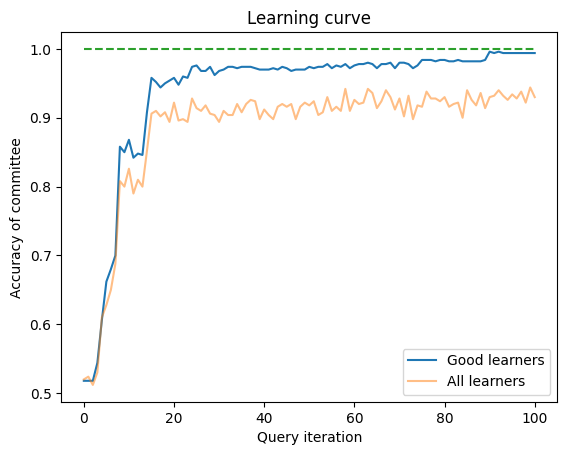

In [447]:
plt.plot(range(n_queries+1), good_perf_hist, label='Good learners')
plt.plot(range(n_queries+1), total_perf_hist, label='All learners', alpha=0.5)
plt.plot(range(n_queries+1), np.ones((n_queries+1,)), linestyle='dashed')
plt.xlabel('Query iteration')
plt.ylabel('Accuracy of committee')
plt.title('Learning curve')
plt.legend()
plt.show()

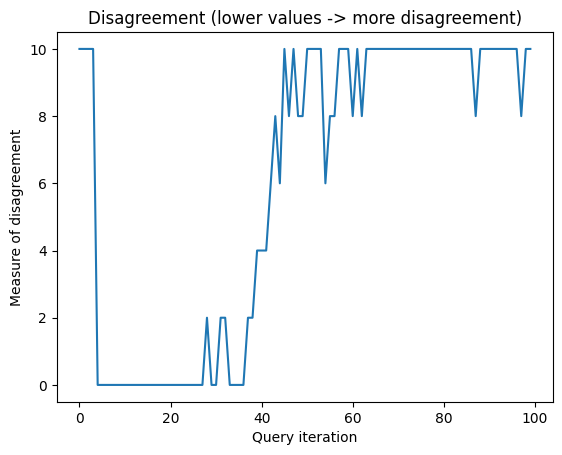

In [310]:
plt.plot(range(n_queries), disagreements)
plt.xlabel('Query iteration')
plt.ylabel('Measure of disagreement')
plt.title('Disagreement (lower values -> more disagreement)')
plt.show()

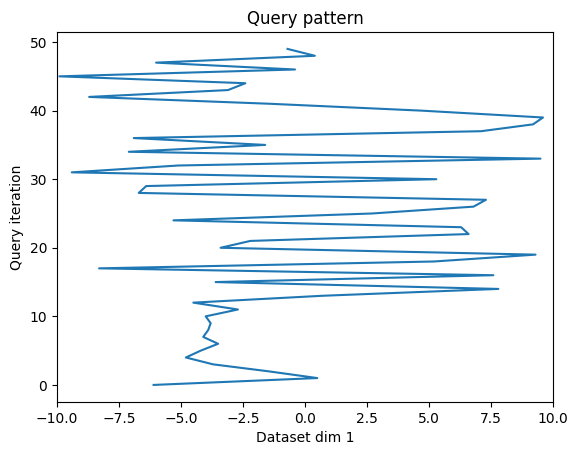

In [42]:
plt.plot(np.array(queries)[:, 0], range(n_queries))
plt.xlim(-10, 10)
plt.xlabel('Dataset dim 1')
plt.ylabel('Query iteration')
plt.title('Query pattern')
plt.show()